In [1]:
from textblob import TextBlob 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D           #Long Short-Term Memory layer - this is just for memory  This version performs the same function as Dropout, however it drops entire 1D feature maps instead of individual elements.
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 
import pandas as pd
import re                      #this is the library for regular expressions
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import sys

In [5]:
data = pd.read_csv('fchasi1.csv')

In [7]:
data.head(2)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1289717837431332865,1289716902428733441,1596327668000,2020-08-02,02:21:08,South Africa Standard Time,299221094,fortunechasi,Fortune Chasi,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '299221094', 'username': 'fortune...",NaN,NaN,NaN,NaN
1,1293568121329061889,1293568121329061889,1597245648000,2020-08-12,17:20:48,South Africa Standard Time,1052968271102795776,gamesreddeer,RedDeerGames,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1052968271102795776', 'username'...",NaN,NaN,NaN,NaN


In [8]:
data['tweet']

0      Iweee? Nenyaknyaka iri ku zesa iyi? Ridding fu...
1      🚨BIG GAME PACK GIVEAWAY🎮\n🚨Click & WIN ➡️  htt...
2      Prior to that power was being supplied 4 next ...
3      There is some truth in saying that covid helpe...
4      Funding is little. REA , by law, gets 6% Zesa’...
5      Yes in the past REA was only concerned with ot...
6      Wry strange situation. Kanzuruz don’t  connect...
7      For sure. REA & zesa now under instruction to ...
8      Zesa fires managers | The Herald  https://www....
9      That’s good news. We will continue to monitor ...
10     I’m very sorry that’s effect on you. The inten...
11                Zesa have been advised and will revert
12     Who are the witnesses?  Saka sa Minister we En...
13     Zesa reuquested a price reduction. It was gran...
14     With respect you are being pedantic. I said th...
15     If you look at the bottom of this order it is ...
16     For a whole year I waited for the parties to m...
17     In addition the Court Or

In [9]:
data['tweet'] = data['tweet'].apply((lambda x: re.sub(r'@[A-Za-z0-9]+','',x)))

In [10]:
data['tweet'] = data['tweet'].apply((lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)))

In [11]:
data['tweet'] = data['tweet'].apply((lambda x: re.sub('[^a-zA-Z]',' ', x)))

In [12]:
data['tweet'] = data['tweet'].apply((lambda x: re.sub(r'\W', ' ', x)))

In [13]:
data['tweet'] = data['tweet'].apply((lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x)))

In [14]:
data['tweet'] = data['tweet'].apply((lambda x:re.sub(r'\^[a-zA-Z]\s+', ' ', x)))

In [15]:
data['tweet'] = data['tweet'].apply((lambda x: re.sub(r'^b\s+', '', x)))

In [16]:
data['tweet'] = data['tweet'].apply(lambda x: x.lower())

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [19]:
from nltk.corpus import stopwords

In [20]:
data['tweet'] = data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [21]:
data['tweet'].values[50]

'hard believe escom fact paid eskom paid last us imports week means zesa negotiate additional supplies available attention turns hcb mozambique'

In [22]:
def word_cloud(tweets):

    x, y = np.ogrid[:300, :300]
    
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)

    word_cloud = WordCloud(width=2000, height=2000, max_font_size=300, 
                           background_color="white", max_words=163, mask=mask, 
                           contour_width=1, contour_color="steelblue",
                           colormap="nipy_spectral").generate(tweets)


    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show()   

In [23]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent

    plt.figure(figsize=(8,5))
    plt.bar(np.arange(30), word_frequency[0][1:31], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "white", capsize=8, linewidth=1);
    plt.xticks(np.arange(0), labels, rotation=90, size=12);
    plt.xlabel("30 more frequent words", size=12);
    plt.ylabel("Frequency", size=12);

    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()


In [24]:
def regression_graph(table):
    table = table[1:]
 
    sns.set_style("whitegrid")   

    plt.figure(figsize=(6,6))
    

    points = plt.scatter(table["Positive"], table["Negative"], c=table["Positive"], s=75, cmap="bwr")

    plt.colorbar(points)
 
    sns.regplot(x="Positive", y="Negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

In [25]:
#Vectorization for Data Visualization
def vectorization(data):

    vector = CountVectorizer()
    
    frequency_matrix = vector.fit_transform(data['tweet'])

    sum_frequencies = np.sum(frequency_matrix, axis=0)

    frequency = np.squeeze(np.asarray(sum_frequencies))

    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

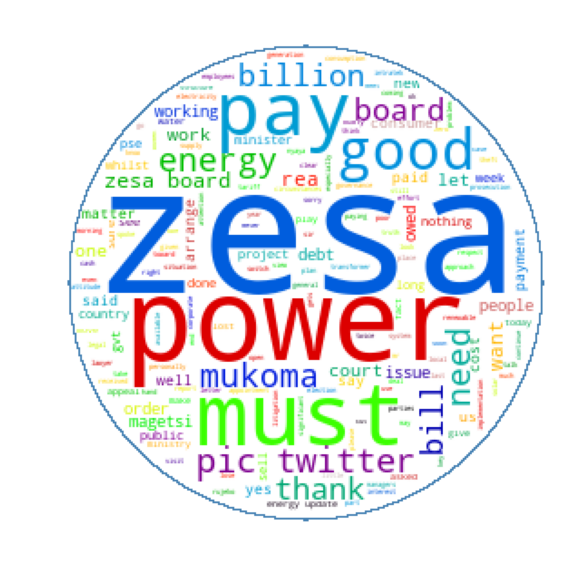

In [26]:
word_cloud(pd.Series([t for t in data.tweet]).str.cat(sep=' ')) 

In [27]:
word_frequency = vectorization(data).sort_values(0, ascending = False)

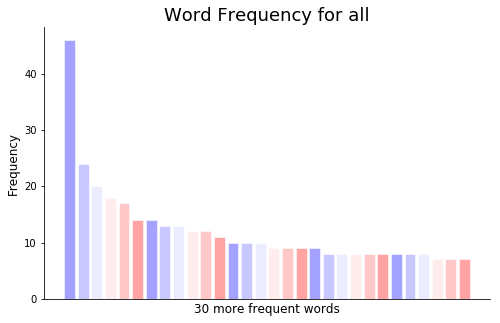

In [28]:
graph(word_frequency,'all')

In [29]:
for i in range(163):
    print(data['tweet'].values[i])
    analysis = TextBlob(data['tweet'].values[i])
    print(analysis.sentiment)
    if analysis.sentiment[0]>0:
        print('Positive')
    elif analysis.sentiment[0]<0:
        print('Negative')
    else:
        print('Neutral')

iweee nenyaknyaka iri ku zesa iyi ridding futi gulaz wo futi
Sentiment(polarity=0.0, subjectivity=0.0)
Neutral
big game pack giveaway click win switch games giveaway reddeergames omg police police clumsy rush nirvanapilotyume cyberprotocol pic twitter com vjmfqp tri
Sentiment(polarity=0.02500000000000001, subjectivity=0.325)
Positive
prior power supplied next nothing result action regard zesa able pay eskom although could clear mozambican debt worked steadfastly toward goal still precondition power
Sentiment(polarity=0.18333333333333335, subjectivity=0.3180555555555556)
Positive
truth saying covid helped reduce power consumption however utterly wrong say explanation long zesa cash flows poor due poor tariff accordingly since may last yr appointed pushed twice
Sentiment(polarity=-0.24583333333333335, subjectivity=0.4902777777777778)
Negative
funding little rea law gets zesa income treasury also gives bit extra zesa customers pay nothing rea also gets nothing know zesa owed us customers 

In [30]:
data['sentiment'] = data['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment[0])

In [31]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


True

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

from nltk import tokenize

sid = SentimentIntensityAnalyzer()

data['sentiment_compound_polarity']=data.tweet.apply(lambda x:sid.polarity_scores(x)['compound'])
data['sentiment_neutral']=data.tweet.apply(lambda x:sid.polarity_scores(x)['neu'])
data['sentiment_negative']=data.tweet.apply(lambda x:sid.polarity_scores(x)['neg'])
data['sentiment_pos']=data.tweet.apply(lambda x:sid.polarity_scores(x)['pos'])
data['sentiment_type']=''
data.loc[data.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
data.loc[data.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
data.loc[data.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'
data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,retweet_date,translate,trans_src,trans_dest,sentiment,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,1289717837431332865,1289716902428733441,1596327668000,2020-08-02,02:21:08,South Africa Standard Time,299221094,fortunechasi,Fortune Chasi,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.0000,1.000,0.000,0.000,NEUTRAL
1,1293568121329061889,1293568121329061889,1597245648000,2020-08-12,17:20:48,South Africa Standard Time,1052968271102795776,gamesreddeer,RedDeerGames,NaN,...,NaN,NaN,NaN,NaN,0.025000,0.5859,0.847,0.000,0.153,POSITIVE
2,1282921755221413888,1282551710553182209,1594707356000,2020-07-14,08:15:56,South Africa Standard Time,299221094,fortunechasi,Fortune Chasi,NaN,...,NaN,NaN,NaN,NaN,0.183333,-0.0772,0.764,0.142,0.095,NEGATIVE
3,1282920992776556544,1282551710553182209,1594707174000,2020-07-14,08:12:54,South Africa Standard Time,299221094,fortunechasi,Fortune Chasi,NaN,...,NaN,NaN,NaN,NaN,-0.245833,-0.8070,0.669,0.267,0.064,NEGATIVE
4,1281539200492490752,1281493718999224320,1594377729000,2020-07-10,12:42:09,South Africa Standard Time,299221094,fortunechasi,Fortune Chasi,NaN,...,NaN,NaN,NaN,NaN,-0.093750,0.1027,0.890,0.048,0.062,POSITIVE


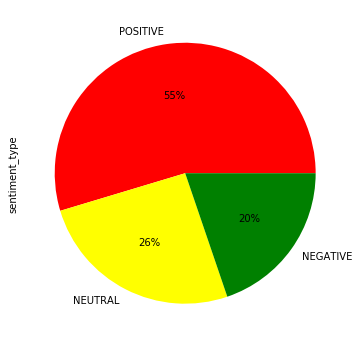

In [33]:
data.sentiment_type.value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(10,6), colors=["red", "yellow", "green"])